<a href="https://colab.research.google.com/github/PedroAMtz/Biomedical_Imaging/blob/main/Chest_X_ray_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet34 CNN model for Chest X-ray classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os, os.path
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from zipfile import ZipFile
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Model

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 73 bytes


In [3]:
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images

labeled-chest-xray-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
file_name = '/content/labeled-chest-xray-images.zip'
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Extraction done')

Extraction done


In [5]:
test_root = '/content/chest_xray/test'
train_root = '/content/chest_xray/train'

In [6]:
def plot_images(main_dir, label=0):

    fnames = os.listdir(main_dir)
    class_1 = os.path.join(main_dir, fnames[label])
    class1_fnames = os.listdir(class_1)

    fig, axs = plt.subplots(nrows=3, ncols=5)
    axs = axs.flatten()

    for i in range(15):
        filepath = os.path.join(class_1, class1_fnames[i])
        img = Image.open(filepath)
        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')
    fig.suptitle('Images from ' + str(fnames[label]))
    plt.show()

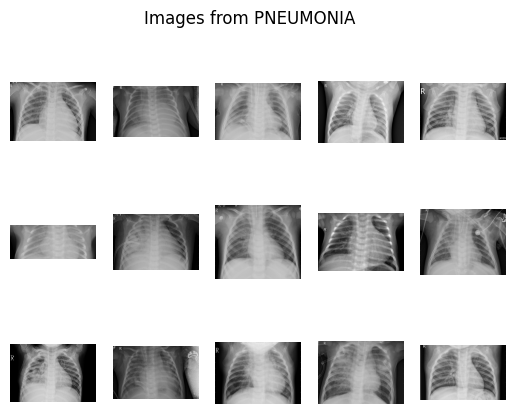

In [7]:
plot_images(train_root, label=1)

In [8]:
def load_data(train_path, test_path, img_shape=(224, 224)):

    batch_size = 34
    norm = 1. / 255.0
    train_dg = ImageDataGenerator(rescale=norm)
    test_dg = ImageDataGenerator(rescale=norm)
    valid_dg = ImageDataGenerator(rescale=norm)

    train_generator = train_dg.flow_from_directory(
        train_path,
        target_size=img_shape,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

    test_generator = test_dg.flow_from_directory(
        test_path,
        target_size=img_shape,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

    return train_generator, test_generator

In [9]:
train_data, test_data = load_data(train_root, test_root);

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# ResNet34 Model

In [10]:
import keras

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides,
                                padding='same', use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1,
                                padding='same', use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides,
                                    padding='same', use_bias=False),
                keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=(224, 224, 3),
                              padding='same', use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(2, activation='softmax'))

model.summary()                                                                    

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 residual_unit (ResidualUnit  (None, 56, 56, 64)       74240     
 )                                                               
                                                        

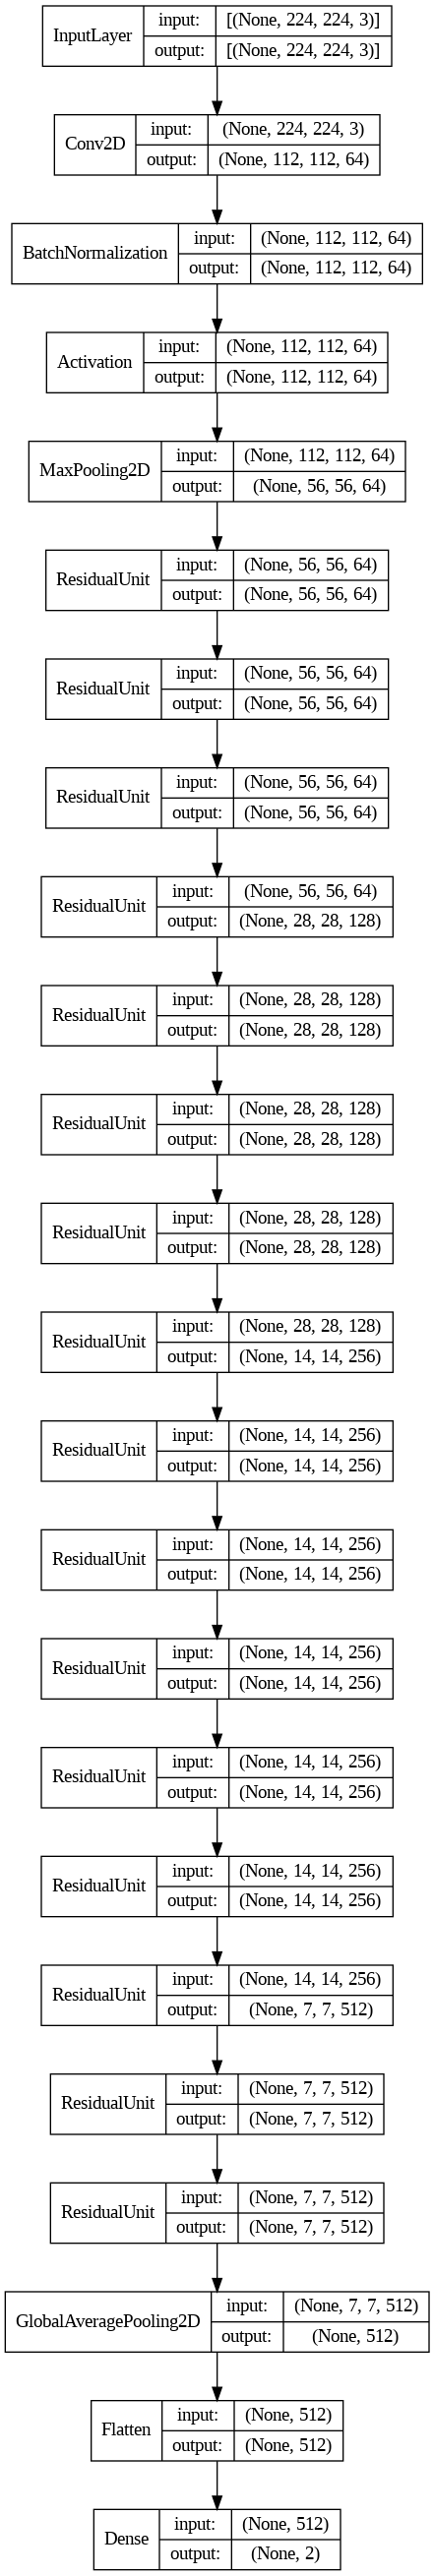

In [11]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

# Defining Training conditions

In [12]:
# Callbacks
filepath=["/content/weights_ResNet34.best.h5"]
checkpoint = ModelCheckpoint(filepath[0], monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=15, 
                          verbose=1, 
                          restore_best_weights=True)

callbacks_list = [checkpoint, earlystop]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [13]:
history = model.fit(train_data,
                    epochs=100, 
                    validation_data=test_data, 
                    callbacks=callbacks_list,
                    verbose = 1,
                    initial_epoch=0)

Epoch 1/100
154/154 [==============================] - ETA: 0s - loss: 0.3439 - accuracy: 0.8914
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to /content/weights_ResNet34.best.h5
154/154 [==============================] - 100s 492ms/step - loss: 0.3439 - accuracy: 0.8914 - val_loss: 4.2954 - val_accuracy: 0.6250
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 0.1496 - accuracy: 0.9429
Epoch 2: val_accuracy did not improve from 0.62500
154/154 [==============================] - 73s 471ms/step - loss: 0.1496 - accuracy: 0.9429 - val_loss: 5.3560 - val_accuracy: 0.6250
Epoch 3/100
154/154 [==============================] - ETA: 0s - loss: 0.1234 - accuracy: 0.9576
Epoch 3: val_accuracy improved from 0.62500 to 0.77404, saving model to /content/weights_ResNet34.best.h5
154/154 [==============================] - 73s 472ms/step - loss: 0.1234 - accuracy: 0.9576 - val_loss: 0.6437 - val_accuracy: 0.7740
Epoch 4/100
154/154 [=========================

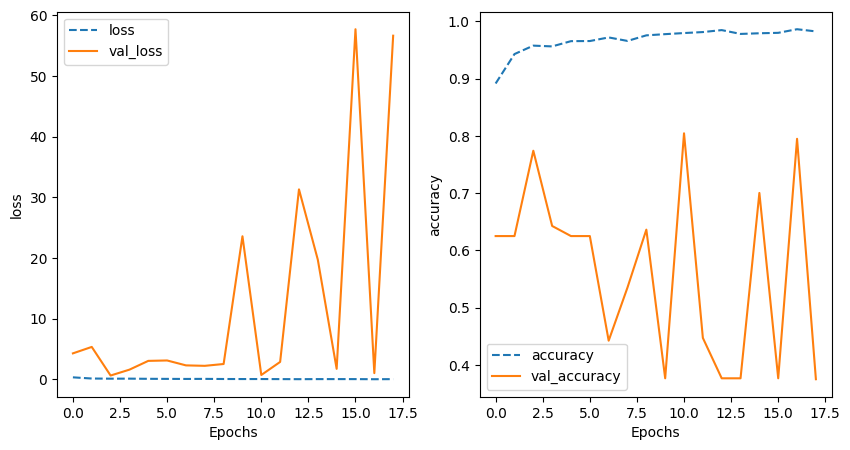

In [15]:
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

training_plot(['loss', 'accuracy'], history)

In [21]:
accuracy = model.evaluate(test_data)
print('Evaluation accuracy of:' , accuracy[1]*100,'%')

19/19 [==============================] - 7s 373ms/step - loss: 0.6437 - accuracy: 0.7740
Evaluation accuracy of: 77.40384340286255 %
